<script type="text/x-mathjax-config">

MathJax.Hub.Config({

  tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}

});

</script>

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=TeX-MML-AM_CHTML' async></script>

## Project6 랜덤 포레스트

### 1. 개요

이번 프로젝트에서는 랜덤 포레스트 모델을 구현한다. 이 모델은 의사결정트리가 필연적으로 가질 수 밖에 없는 과대적합 문제를 해소하기 위해 만들어진 모델로, 앙상블 기법에 의해 구성되며 부트스트래핑과 무작위성을 도입해 데이터의 분산을 최소화한다. 

데이터의 분석과 시각화를 위해서 미리 정의해둔 플로팅 함수들을 사용한다. 해당 함수들은 projectfiles.analyzer.graphics에 정의되어있다.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from projectfiles.analyzer.graphics import plot_decision_regions, plot_data
from projectfiles.analyzer.statistics import classification_accuracy
from projectfiles.decision_tree import DecisionTreeClassifier, gini

### 2. 인공지능 모델의 과소적합

랜덤 포레스트를 구현하기에 앞서 먼저 인공지능 모델의 과소적합 문제를 잠깐 소개하고자. 과소적합의 정의는 다음과 같다:

<blockquote>과소적합은 모델의 학습 알고리즘의 복잡도가 너무 낮아 훈련 데이터셋을 제대로 학습하지 못하는 경우를 말한다</blockquote>

다시 말해 과소적합은 모델의 구조적 한계 혹은 하이퍼 파라미터의 특성으로 인해 모델이 훈련 데이터셋을 제대로 학습하지 못하는 것을 말한다. 예를 들어 SVM과 같은 선형 이진 분류기 모델에 선형적 결정경계로 구분될 수 없는 데이터셋을 학습시키는 경우가 이에 해당한다. SVM은 기본적으로 두 개의 데이터 클레스 레이블을 최대한 잘 구분하는 선형 방정식을 찾는 방식으로 동작하는데, 이러한 알고리즘으로는 절대 비선형적인 경향성을 보이는 데이터셋을 학습할 수 없다. 따라서 SVM으로 이러한 데이터셋을 학습하기 위해서는 알고리즘의 복잡도를 늘려야 하며, 일반적인 SVM 모델로는 이를 학습할 수 없다.

사이킷런의 SVM 모델이나 혹은 기타 다른 라이브러리들에서는 커널 트릭이나 슬랙 변수등을 활용하여 모델이 비선형적 결정 경계를 생성할 수 있도록 알고리즘을 개선한다. 커널 트릭(kernel trick)은 커널 함수를 통해 데이터의 차원 수를 높이고 변형한 뒤, 모델이 이를 구분하는 초평면(hyper-plane)을 찾도록 하는 알고리즘을 말한다. 그리고 슬랙 변수(slack variable)를 이용한 알고리즘은 새로운 변수를 도입하여 모델이 특정한 이상치들에 대한 내성을 갖도록 디자인 되어 있다. 이처럼 알고리즘의 복잡도를 높임으로서 결정 경계의 복잡도 또한 높일 수 있으며, 이러한 방법으로 과소적합 문제를 해결할 수 있다.

하이퍼 파라미터 또한 과소적합 문제의 원인일 수 있다. 앞서 구현한 로지스틱 회귀 모델의 경우, 반복 횟수를 정의하는 변수 n_iter가 작을 경우, 학습이 제대로 이루어지지 않을 수 있다. 이는 로지스틱 회귀 알고리즘의 복잡도가 반복 횟수에 의해 크게 좌우되기 때문이다. 이처럼 학습이 완료된 모델이 신뢰도 높은 결과를 보이지 않을 때는 하이퍼 파라미터를 변경한 후 다시 학습함으로서 문제를 해결할 수도 있다. 

### 3. 인공지능 모델의 과대적합

과대적합은 과소적합과는 반대로 인공지능 모델의 내부 알고리즘이 너무 복잡하여 훈련 데이터셋에는 잘 맞지만 추가적인 데이터들에는 잘 맞지 않는 경우를 말한다. 이를 정리하면 다음과 같다:

<blockquote>과대적합은 내부 알고리즘이 지나치게 복잡하여 모델이 일반성을 잃어버리는 경우를 말한다</blockquote>

예를 들어 앞선 프로젝트에서 구현한 의사결정트리의 경우 트리의 깊이에 따라 알고리즘의 복잡도가 결정된다. 트리의 깊이가 깊어질수록 결정 경계는 더욱 복잡해지며, 이상치에 취약해진다. 일반적으로 모델이 이상치에 취약해지면 일반적인 데이터들을 예측하는데 불리하다.

다음 예제를 통해 이를 확인해보자. 아래 코드는 트리의 최대 깊이(max_depth)가 7일 때 의사결정트리가 생성하는 결정경계를 나타낸 것이다.

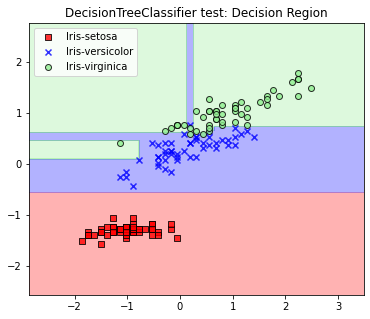

train set accuracy: 98.00%


In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

y = df.iloc[0:150, 4].values
ynames = {}

for idx, lbl in enumerate(np.unique(y)):
    y[np.where(y == lbl)] = idx
    ynames[idx] = lbl

X = df.iloc[0:150, [0, 2]].values

# standardization of the samples
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# fitting model
model = DecisionTreeClassifier(criterion='gini', max_depth=7)
model.fit(X_std, y, toler=0.0001)

# plotting result
result = plt.figure(figsize=(6, 5))
ax = result.add_subplot()

plot_decision_regions(X_std, y, model, resolution=0.02, names=ynames, ax=ax)
ax.set_title('DecisionTreeClassifier test: Decision Region')
ax.legend(loc='upper left')

plt.show()

print(f"train set accuracy: {classification_accuracy(model, X_std, y)*100:.2f}%")

훈련 데이터에 대한 정확도는 98%로 높은 편이지만, 트리의 결정 경계가 지나치게 많이 복잡함을 확인할 수 있다. 이런 경우 새로운 데이터에 대해 올바르지 않은 예측을 수행할 가능성이 높아지기 때문에 위의 의사결정트리는 올바르게 학습되었다고 보기 어렵다.

그렇다면 트리의 최대 깊이를 3으로 하면 어떻게 될까?

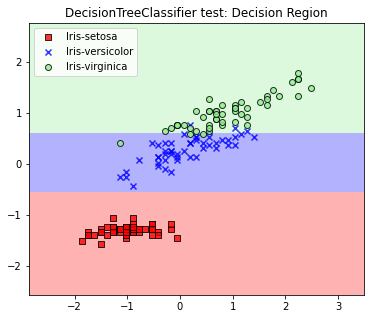

train set accuracy: 95.33%


In [3]:
# fitting model
model = DecisionTreeClassifier(criterion='gini', max_depth=3)
model.fit(X_std, y, toler=0.0001)

# plotting result
result = plt.figure(figsize=(6, 5))
ax = result.add_subplot()

plot_decision_regions(X_std, y, model, resolution=0.02, names=ynames, ax=ax)
ax.set_title('DecisionTreeClassifier test: Decision Region')
ax.legend(loc='upper left')

plt.show()

print(f"train set accuracy: {classification_accuracy(model, X_std, y)*100:.2f}%")

지금의 경우에는 훈련 데이터셋에 대한 정확도가 95%로 다소 감소하였으나 훨씬 일반적인 형태의 결정 경계가 생성되었다. 따라서 새로운 데이터에 대한 예측을 더 잘 수행할 것을 기대할 수 있다. 이처럼 내부 알고리즘의 복잡도를 낮추는 방법을 이용해 과대적합문제를 해결할 수 있다.

의사결정트리의 깊이를 제한하는 방법을 흔히 가지치기(pruning)이라고 한다. 일부 하위트리를 제거함으로써 불순도가 다소 높아지더라도 검증 데이터셋에 대한 정확도를 끌어올리는 기법이다. 따라서 가지치기를 적용하면 더 간단한 형태의 의사결정트리가 생성된다(오컴의 면도날). 가지치기 알고리즘에는 흔히 사전 가지치기와 사후 가지치기가 있다. 앞선 프로젝트에서 구현한 의사결정트리에는 사전 가지치기가 적용되어있으며, mat_depth에 의해 트리의 최대 깊이가 제한되고, toler 옵션에 의해 일정 이상의 불순도 역치를 넘어서지 못하는 노드는 생성되지 않도록 제한하였다.

사후 가지치기는 다른 방식으로 작동한다. 사후 가지치기는 훈련을 시행 하기에 앞서 먼저 훈련용 데이터셋과 원본 데이터셋을 분리하고, 훈련용 데이터셋으로 학습을 진행한 다음, 트리의 각 노드들을 순회하면서 검증용 데이터셋에 대한 오분류율이 증가하는 기점의 하위 트리들을 트리에서 제거하는 방식이다.

위에서 제시한 방법들을 이용하면 앞서 구현한 의사결정트리의 알고리즘을 크게 변형하지 않으면서 과대적합을 피할 수 있다.

### 4. 앙상블 기법 개요

앞서 의사결정트리의 과대적합을 피하기 위해 내부 알고리즘을 단순화하는 다양한 방법들을 제시하였다. 위에서 제시한 방법들을 이용하면 어느정도 과대적합을 피할 수 있다. 그러나 내부 알고리즘을 단순히하는 것은 모델의 성능을 하락시키게 되므로 이상치가 아닌 데이터들의 학습에도 지장이 있을 수 있다. 따라서 모델의 성능이 지나치게 하락되지 않는 선에서 최대한 모델을 단순화하는 하이퍼 파라미터를 정의하는 것은 상당히 까다로운 작업이므로, 과대적합을 피하기 위한 근본적인 해결책이 필요하다.

앞서 말한 이류로 인해 보통 의사결정트리는 단독으로 사용되기 보다는 앙상블 기법(ensemble method)에 의해 여러 모델들의 결합하여 사용하는 것이 일반적이다. 앙상블 기법의 종류로는 크게 네가지가 있다:

1. 보팅(voting)

    * 서로 다른 알고리즘으로 동작하는 여러 개의 모델들을 결합하여 각 모델들의 예측 결과를 바탕으로 보다 정확한 예측값을 끌어내는 앙상블 기법이다.
    * 신뢰도 높은 결과를 도출하기 위해 사용한다.
   

2. 배깅(bagging, bootstrap aggregating)

    * 서로 같은 알고리즘으로 동작하는 여러 개의 모델들을 결합하여 각 모델들의 예측 결과를 바탕으로 보다 정확한 예측값을 끌어내는 앙상블 기법이다.
    * 부트스트래핑(bootstraping)을 이용하여 생성된 여러 개의 훈련데이터셋을 이용한다.
    * 데이터셋의 크기가 커지므로 과대적합을 해소하는데 용이하다


3. 부스팅(boosting)

    * 모델의 학습이 순차적으로 수행되며 오분류된 데이터들에 대한 가중치를 갱신하며 모델이 오분류된 데이터들을 더 잘 분류할 수 있도록 개선한다.
    * 예측 성능이 뛰어나나 속도가 느리다.
    

4. 스태킹(stacking)

    * 데이터셋을 여러 개의 폴드(fold)로 나누고 이를 이용하여 여러 개의 모델들을 교차검증(cross validation)하며 학습한다. (k-fold cross validation)
    * 정확도는 높으나 이상치들에 취약하다.
    
각 앙상블 기법들에 대한 자세한 설명은 다른 문서들을 참고한다. 랜덤 포레스트를 구현하는데는 배깅 기법을 이용하므로 이번 프로젝트에서는 이에 대한 구현만 진행한다.

### 5. 데이터셋의 부트스트래핑 개요

부트스트래핑은 데이터셋에서 무작위로 몇 개의 데이터 샘플들만을 포함하는 새로운 데이터셋을 생성하는 기법이다. 이는 통계학에서 주로 사용하는 용어로 용어의 자세한 정의는 여기서 설명하지 않는다. 부트스트래핑을 이용하면 비슷한 특성을 갖는 데이터셋을 여러 개 생성할 수 있다.

부트스트래핑은 다음과 같이 수행된다:

<blockquote>데이터셋에서 중복을 허용하여 무작위로 특정 개수만큼의 데이터 샘플들만을 추출한다</blockquote>

numpy.random.choice() 메소드를 이용하면 쉽게 부트스트랩을 생성할 수 있다. 아래 코드는 data라는 임의의 벡터를 부트스트래핑하는 예제이다.

In [4]:
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
rgen = np.random.RandomState(seed=1)

boot1 = rgen.choice(data, size=data.shape[0])
boot2 = rgen.choice(data, size=data.shape[0])
boot3 = rgen.choice(data, size=data.shape[0])
boot4 = rgen.choice(data, size=data.shape[0])

print(boot1)
print(boot2)
print(boot3)
print(boot4)

[6 9 6 1 1 2 8 7 3]
[5 6 3 5 3 5 8 8 2]
[8 1 7 8 7 2 1 2 9]
[9 4 9 8 4 7 6 2 4]


앞서 말했듯 부트스트래핑을 이용하여 모델의 학습을 수행하면 과대적합을 어느정도 완화할 수 있다. 예를 들어 다음과 같이 data의 평균을 구했다고 가정해보자.

In [5]:
mean_val = data.mean()

mean_val

5.0

이는 고정된 값으로 평균을 구할 때 벡터 내의 모든 원소들이 사용되었다. 만약 data가 이상치들을 포함하지 않았을 경우에 이 값은 완벽하게 맞는 값이 된다. 하지만 벡터에 이상치가 존재하는 경우 위의 방법을 통해 구해진 값은 완벽하게 틀린 값이다. 이번에는 부트스트래핑을 이용해보자. 

In [6]:
boot_mean_val = []

for _ in range(10):
    boot = rgen.choice(data, size=data.shape[0])
    boot_mean_val.append(boot.mean())

mean_val = np.array(boot_mean_val).mean()

mean_val

5.0666666666666655

위의 코드는 총 10 개의 부트스래핑된 벡터들을 생성하고 그들의 평균을 구한 뒤, 그 평균값들에 대한 평균을 출력한 것이다. 물론 이 값은 실제 평균값이 될 수 없다. 다만 이 값은 이상치를 제거한 평균값일 수는 있다. 위의 코드를 반복실행하면 항상 다른 값이 나오게 되는데 이들 중 하나는 어쩌면 완벽하게 이상치가 제거된 평균값일 수 있다. 이처럼 부트스트래핑을 이용하면 평균값이 될 수 있는 신뢰도 높은 값들에 대한 범위를 구할 수 있다.

###  6. 랜덤 포레스트의 구현

앞서 부트스트래핑을 이용하여 이상치를 완화하는 방법에 대해 알아보았다. 이를 활용해 이번에는 직접 랜덤 포레스트를 구현한다.

랜덤 포레스트 모델의 학습과정은 다음과 같다:

1. N개의 의사결정모델들을 생성한다.
2. 부트스트래핑을 통해 N개의 데이터셋을 생성한다.
3. 각 모델에 N개의 부트스트랩 데이터셋을 학습시킨다.

그리고 예측과정은 다음과 같다:

1. 각각의 모델들에 대해 데이터 레이블을 예측한다.
2. 레이블들 중 가장 많이 발견된 값을 예측값으로 한다.

알고리즘 자체는 매우 단순하다. 랜덤 포레스트를 구현하기 위해 앞선 프로젝트에서 구현했던 DecisionTreeClassifier 모듈을 이용한다.

In [7]:
class RandomForest(object):
    def __init__(self, n_estimators=100, criterion=gini, max_depth=None, random_state=None):
        self.n_estimators = n_estimators  # 의사결정트리 모델의 개수
        self.criterion = criterion        # 각 모델들의 불순도 기준 (gini, entropy ...)
        self.max_depth = max_depth        # 각 트리의 최대 깊이
        self.random_state = random_state  # random seed
        self.rgen = np.random.RandomState(self.random_state)  # random number generator
        
        # N개의 의사결정트리 모델 생성
        self.submodels = [DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth)
                          for _ in range(self.n_estimators)]
        self.label_names = None  # 클래스 레이블 이름들 저장

    def fit(self, data, label, toler=0.001):
        self.label_names = np.unique(label)
        
        # 각 의사결정트리에 대한 부트스트랩 데이터셋을 생성하고 이를 이용하여 모델을 학습한다
        for midx, model in enumerate(self.submodels):
            # 부트스트랩 데이터셋 생성
            didx = self.rgen.choice(range(0, data.shape[0], 1), size=data.shape[0])
            boot_data, boot_label = data[didx], label[didx]
            # 모델의 학습 진행
            model.fit(boot_data, boot_label, toler=toler)

        return self

    def predict(self, data):
        # 데이터가 일차원일 때 예측
        if len(data.shape) == 1:
            predicted_labels = [model.predict(data) for model in self.submodels]
            counts, labels = np.unique(predicted_labels)
            return labels[np.where(counts == max(counts))[0][0]]
        
        # 데이터가 이차원일 때 예측
        voting = np.zeros(shape=(data.shape[0], self.label_names.shape[0]))  # 각 모델들의 예측결과 저장

        for model in self.submodels:
            label_predicted = model.predict(data)
            for lidx, lbl in enumerate(self.label_names):
                voting[np.where(label_predicted == lbl), lidx] += 1
        
        # 가장 많이 예측된 클래스 레이블을 리턴
        return np.array([self.label_names[np.where(vec == max(vec))[0][0]] for vec in voting])

그리고 아래 코드는 위에서 구현한 모델을 이용하여 학습한 결과를 출력하는 코드이다.

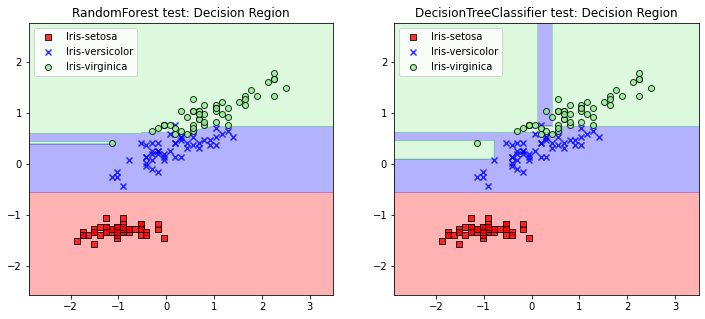

DTmodel accuracy: 97.33% (Decision Tree)
RFmodel accuracy: 98.67% (Random Forest)


In [8]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

y = df.iloc[0:150, 4].values
ynames = {}

for idx, lbl in enumerate(np.unique(y)):
    y[np.where(y == lbl)] = idx
    ynames[idx] = lbl

X = df.iloc[0:150, [0, 2]].values

# standardization of the samples
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# fitting model (RandomForest)
RFmodel = RandomForest(n_estimators=100, criterion='gini', max_depth=5, random_state=1)
RFmodel.fit(X_std, y, toler=0.0001)

# fitting model (DecisionTreeClassifier)
DTmodel = DecisionTreeClassifier(criterion='gini', max_depth=5)
DTmodel.fit(X_std, y, toler=0.0001)

# plotting result
result = plt.figure(figsize=(12, 5))
ax1 = result.add_subplot(1, 2, 1)
ax2 = result.add_subplot(1, 2, 2)

plot_decision_regions(X_std, y, RFmodel, resolution=0.02, names=ynames, ax=ax1)
ax1.set_title('RandomForest test: Decision Region')
ax1.legend(loc='upper left')

plot_decision_regions(X_std, y, DTmodel, resolution=0.02, names=ynames, ax=ax2)
ax2.set_title('DecisionTreeClassifier test: Decision Region')
ax2.legend(loc='upper left')
    
plt.show()

print(f"DTmodel accuracy: {classification_accuracy(DTmodel, X_std, y)*100:.2f}% (Decision Tree)")
print(f"RFmodel accuracy: {classification_accuracy(RFmodel, X_std, y)*100:.2f}% (Random Forest)")

보다시피 결정 경계의 복잡도가 눈에 띄게 감소한 것을 볼 수 있다. 어떻게 이것이 가능한 것일까? 이것은 앞서 설명한 부트스트래핑의 특성 때문이다. 랜덤 포레스트 내부의 의사결정트리들은 각각 서로 다른 이상치들이 제거된 데이터셋들로 학습한다. 따라서 이들을 이용하여 예측을 수행했을 때 가장 많이 예측된 레이블은 가장 신뢰도 높은 결과값으로 간주될 수 있다. 이러한 이유로 인해 랜덤 포레스트로 생성된 결정 경계가 좀 더 일반적인 것이라고 할 수 있다.

위와 같은 방식의 앙상블 기법을 배깅이라 한다. 랜덤 포레스트는 배깅을 사용하는 대표적인 알고리즘이다.

위에서 구현한 랜덤 포레스트 모델은 projectfiles.decision_tree에 RandomForest라는 이름으로 구현되어있다. 이 모델에는 각 모델들에 랜덤하게 특징 요소를 할당하는 부분이 추가되어있으니 참고하라